## Environment

In [1]:
import sys
import os
from pathlib import Path
import dask.dataframe as dd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

from scipy import stats

# Setup project root path
project_root = Path.cwd()
if 'notebooks' in str(project_root):
    project_root = project_root.parent

# Add src to path
src_path = str(project_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Set results path
data_dir = project_root / 'data'

pd.options.display.max_columns = 999

## Elasticity calculation

In [2]:
# def calculate_grid_elasticity(grid_data, q_k_col='qk', soc_int_col='sk', min_users=10):
#     """Calculate elasticity using log-log regression: ε = ∂ln(S_K)/∂ln(q_K)"""
    
#     valid_data = grid_data[
#         (grid_data[q_k_col] > 0) & 
#         (grid_data[soc_int_col] > 0) & 
#         (grid_data[q_k_col].notna()) & 
#         (grid_data[soc_int_col].notna())
#     ].copy()
    
#     if len(valid_data) < min_users:
#         return {'es': np.nan, 'r2': np.nan, 'p': np.nan, 'n_users': len(valid_data), 'stderr': np.nan}
    
#     log_qk = np.log1p(valid_data[q_k_col])
#     log_soc = np.log1p(valid_data[soc_int_col])
    
#     slope, r_value, p_value, std_err = stats.linregress(log_qk, log_soc)
    
#     return {
#         'es': slope,
#         'r2': r_value ** 2,
#         'p': p_value,
#         'n_users': len(valid_data),
#         'stderr': std_err
#     }


# def compute_es_by_grid(user_data, groupby_col='home_grd_id', q_k_col='qk', soc_int_col='sk', min_users=10):
#     """
#     Compute elasticity for each grid cell and return DataFrame
    
#     Parameters:
#     -----------
#     user_data : pd.DataFrame
#         User-level data containing grouping and variable columns
#     groupby_col : str
#         Grouping column name (default: 'home_grd_id')
#     q_k_col : str
#         K-value column name (default: 'qk')
#     soc_int_col : str
#         Social interaction column name (default: 'sk')
#     min_users : int
#         Minimum user count threshold (default: 10)
        
#     Returns:
#     --------
#     pd.DataFrame
#         Grid-level data containing elasticity and statistical measures
#     """
#     results = []
    
#     for grd_id, group_data in user_data.groupby(groupby_col):
#         if pd.isna(grd_id):
#             continue
        
#         result = calculate_grid_elasticity(group_data, q_k_col, soc_int_col, min_users)
#         result['grd_id'] = grd_id
#         results.append(result)
    
#     return pd.DataFrame(results)


import segregation_elasticity as el

# Sample usage: 
# user_elasticity = pd.read_csv("results/user_qk_segregation-final.csv")
# grid_es = el.compute_es_by_grid(user_elasticity, 'home_grd_id', 'qk', 'sk')

## Bivariate plot of income and elasticity quartiles

In [3]:
grid_es = gpd.read_parquet(data_dir / 'es-final.parquet')

In [4]:
def _cut_city_to_E(series):
    s = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    if s.notna().sum() < 4:
        return pd.Series([pd.NA] * len(s), index=s.index)
    return pd.qcut(
        s,
        q=4,
        labels=['E1','E2','E3','E4'],
    )

grid_es['es_quar'] = (
    grid_es
      .groupby('region')['es']
      .transform(_cut_city_to_E)
)

# Create a bivariate classification like "Q1_E1", "Q2_E3", etc.
def create_bivariate_class(row):
    income_q = row['inc_quar']
    elasticity_q = row['es_quar']
    return f"{income_q}_{elasticity_q}"

grid_es['bivariate_class'] = grid_es.apply(create_bivariate_class, axis=1)


bivar_colors = {
    'Q4_E1': '#240D5E', 'Q4_E2': '#5E5673', 'Q4_E3': '#A3694D', 'Q4_E4': '#B30000',
    'Q3_E1': '#554089', 'Q3_E2': '#7F749C', 'Q3_E3': '#BE7260', 'Q3_E4': '#E2411C',
    'Q2_E1': '#8E7CB7', 'Q2_E2': '#B0A8C1', 'Q2_E3': '#D9AB96', 'Q2_E4': '#F6753C',
    'Q1_E1': '#C3B3D8', 'Q1_E2': '#DDD8E2', 'Q1_E3': '#ECDFCC', 'Q1_E4': '#FFCC80'
}

def plot_bivariate_map(city_list, xlim=None, ylim=None):
    # Filter for specific cities
    city_data = grid_es[grid_es['city'].isin(city_list)].copy()
    
    if city_data.empty:
        print(f"No data for {city_list}")
        return

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    # Plot bivariate data classes
    for bivar_class, color in bivar_colors.items():
        subset = city_data[city_data['bivariate_class'] == bivar_class]
        if not subset.empty:
            subset.plot(ax=ax, color=color, 
                        edgecolor='white', linewidth=1)

    # Set equal aspect
    ax.set_aspect('equal')

    # Set explicit limits if provided
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # Add basemap
    try:
        ctx.add_basemap(ax, crs=city_data.crs.to_string(), 
                       source=ctx.providers.CartoDB.Positron, alpha=0.3,
                       attribution=False)
    except:
        pass

    ax.axis('off')
    plt.tight_layout()
    plt.show()

### Figure 6a: Bivariate map of Helsinki region

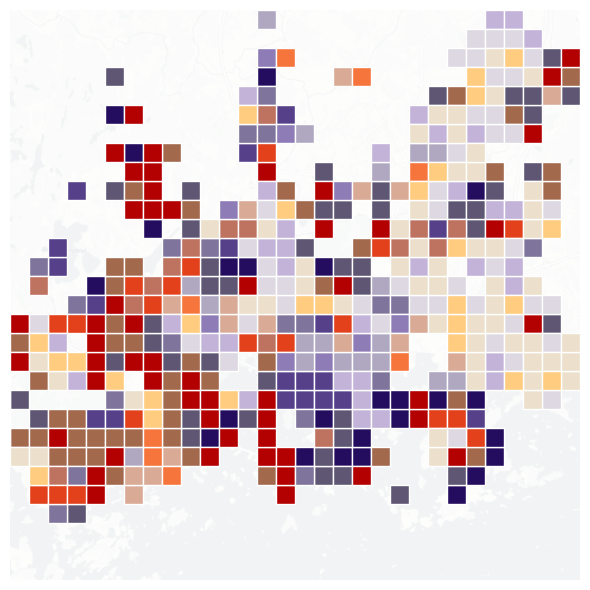

In [5]:
helsinki_cities = ['Helsinki', 'Espoo', 'Vantaa', 'Kauniainen']

plot_bivariate_map(helsinki_cities, xlim=(368000, 398000), ylim=(6665000, 6665000 + 30000))

### Figure S[]: Bivariate map of Tampere, Turku and Oulu regions

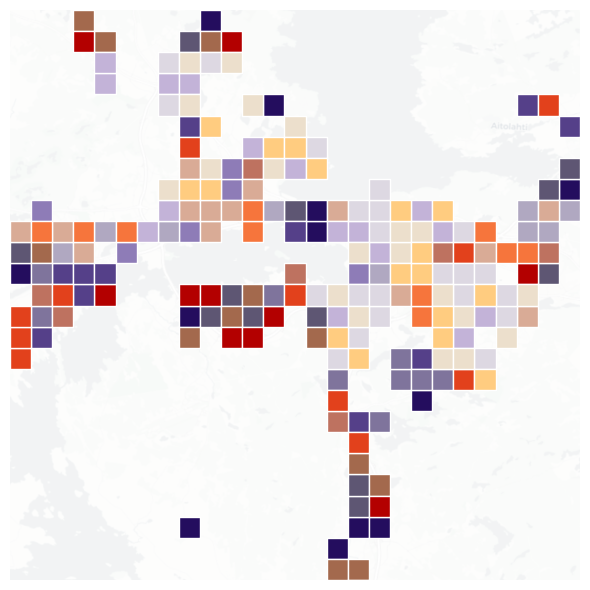

In [6]:
# Filter for Tampere metropolitan area
tampere_cities = ['Tampere', 'Pirkkala', 'Lempäälä', 'Ylöjärvi','Nokia']

# Use the function to plot
plot_bivariate_map(tampere_cities, xlim=(311000, 338000), ylim=(6806000, 6806000 + 27000))

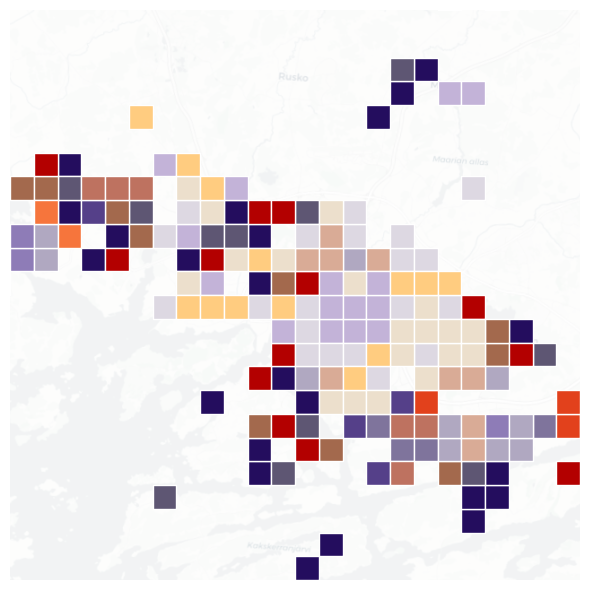

In [7]:
# Filter for Turku region
turku_cities = ['Turku', 'Kaarina', 'Naantali', 'Raisio']

# Use the function to plot
plot_bivariate_map(turku_cities, xlim=(226000, 250000), ylim=(6700000, 6724000))

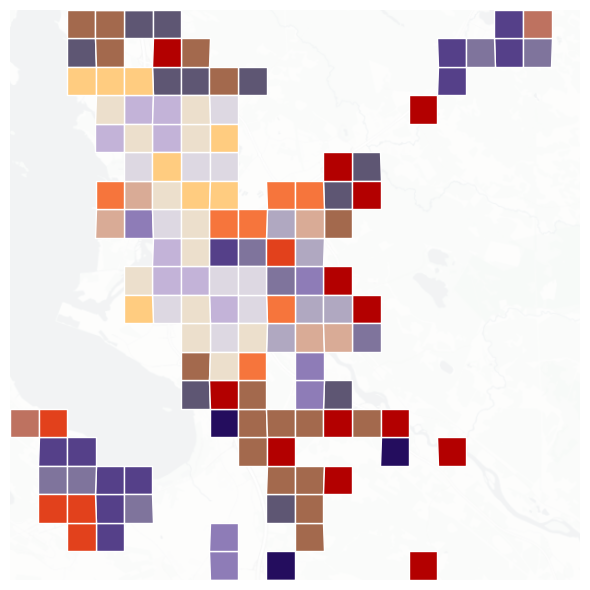

In [8]:
oulu_cities = ['Oulu', 'Kempele', 'Li','Liminka', 'Tyrnävä']
    
plot_bivariate_map(oulu_cities, xlim=(422000, 442000), ylim=(7200000, 7220000))

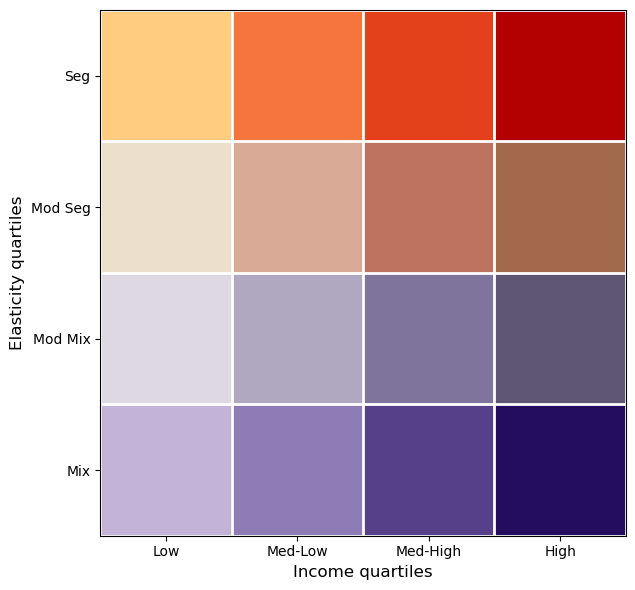

In [9]:
# Create a separate legend for the bivariate map
fig_legend, ax_legend = plt.subplots(1, 1, figsize=(8, 6))

income_labels = ['Q1', 'Q2', 'Q3', 'Q4']
elasticity_labels = ['E1', 'E2', 'E3', 'E4']

# Build color matrix
legend_matrix = np.arange(16).reshape(4, 4)
colors = [bivar_colors[f"{income_labels[j]}_{elasticity_labels[3-i]}"] 
          for i in range(4) for j in range(4)]

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(colors)

# Plot legend
ax_legend.imshow(legend_matrix, cmap=custom_cmap, aspect='equal')

# Set labels
ax_legend.set_xticks(range(4))
ax_legend.set_yticks(range(4))
ax_legend.set_xticklabels(['Low', 'Med-Low', 'Med-High', 'High'])
ax_legend.set_yticklabels(['Seg', 'Mod Seg', 'Mod Mix', 'Mix'])
ax_legend.set_xlabel('Income quartiles', fontsize=12)
ax_legend.set_ylabel('Elasticity quartiles', fontsize=12)

# Add grid lines
for i in range(5):
    ax_legend.axhline(i - 0.5, color='white', linewidth=2)
    ax_legend.axvline(i - 0.5, color='white', linewidth=2)

plt.tight_layout()
plt.show()


## LISA

### LISA Analysis for income and elasticity (numerical)

In [10]:

from libpysal.weights import Queen, Rook
from esda.moran import Moran_Local_BV

def calculate_bivar_lisa(gdf, x_col, y_col):
    """
    Calculate Bivariate Local Moran's I and assign cluster labels/colors.
    """
    # Use only rows with both values present
    g = gdf.dropna(subset=[x_col, y_col]).copy()
    
    if len(g) < 2:
        return g

    # Spatial weights (Queen); row-standardized
    w = Queen.from_dataframe(g, silence_warnings=True)
    w.transform = "r"

    x = g[x_col].values
    y = g[y_col].values
    lisa = Moran_Local_BV(x, y, w, seed=33, permutations=999)

    # Cluster labels and significance
    g['lisa_q'] = lisa.q
    g['lisa_p'] = lisa.p_sim
    g['lisa_sig'] = np.where(g['lisa_p'] <= 0.05, g['lisa_q'], 0)

    # Label/color map
    labels = {
        1: "High Income / High elasticity (HH)",
        2: "Low Income / High elasticity (LH)",
        3: "Low Income / Low elasticity (LL)",
        4: "High Income / Low elasticity (HL)",
        0: "Not significant"
    }
    colors = {
        1: "#8B0000",  # red
        2: "#6099D4",  # blue
        3: "#003366",  # dark blue
        4: "#C46682",  # pink/orange
        0: "#CBCFD3"   # gray
    }

    g['lisa_label'] = g['lisa_sig'].map(labels)
    g['lisa_color'] = g['lisa_sig'].map(colors)
    
    return g

### Figure 6b-d: LISA plots for income and elasticity in Helsinki, Tampere, Turku and Oulu

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_6152/1462844277.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(g, silence_warnings=True)
/Users/silver/anaconda3/envs/spatial/lib/python3.11/site-packages/esda/moran.py:1827: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


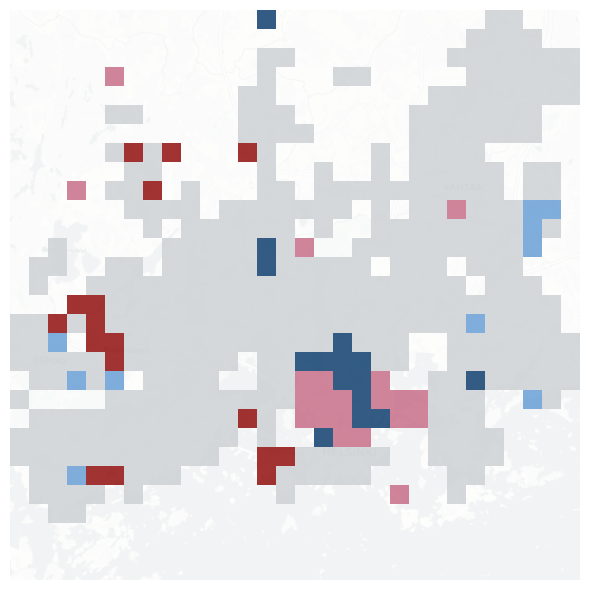

In [11]:
helsinki_cities = ['Helsinki', 'Espoo','Vantaa','Kauniainen',]

grid_helsinki = grid_es[grid_es['city'].isin(helsinki_cities)]
g = grid_helsinki.dropna(subset=['md_inc', 'es']).copy()

g = calculate_bivar_lisa(g, 'md_inc', 'es')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
g.plot(color=g['lisa_color'], linewidth=0, edgecolor='white', ax=ax, alpha=0.8)
ax.set_axis_off()

ax.set_xlim(368000, 398000)
ax.set_ylim(6665000, 6665000 + 30000)

ctx.add_basemap(ax, crs=grid_es.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron, alpha=0.3,
                attribution = False)

plt.tight_layout()
plt.show()

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_6152/1462844277.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(g, silence_warnings=True)
/Users/silver/anaconda3/envs/spatial/lib/python3.11/site-packages/esda/moran.py:1827: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


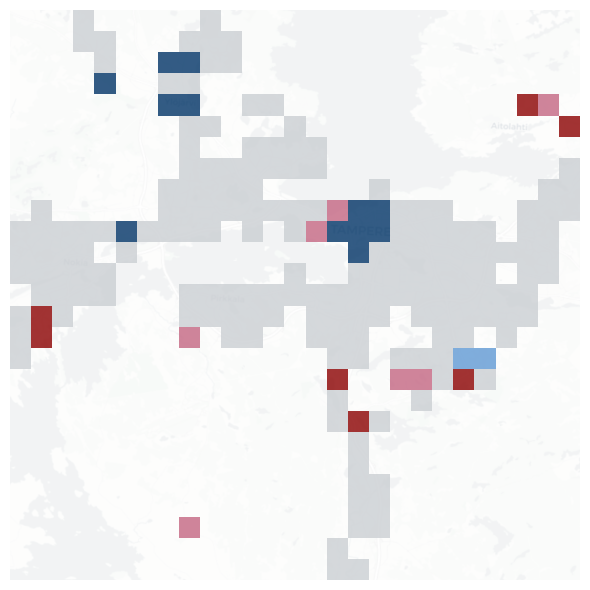

In [12]:

tampere_cities = ['Tampere', 'Pirkkala', 'Lempäälä', 'Ylöjärvi','Nokia']
city_data = grid_es[grid_es['city'].isin(tampere_cities)].copy()


g = city_data.dropna(subset=['md_inc', 'es']).copy()
g = calculate_bivar_lisa(g, 'md_inc', 'es')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
g.plot(color=g['lisa_color'], linewidth=0, edgecolor='white', ax=ax, alpha=0.8)
ax.set_axis_off()


ax.set_xlim(311000, 338000)
ax.set_ylim(6806000, 6806000 + 27000)

ctx.add_basemap(ax, crs=grid_es.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron, alpha=0.3,
                attribution = False)

ax.axis('off')
plt.tight_layout()
plt.show()

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_6152/1462844277.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(g, silence_warnings=True)
/Users/silver/anaconda3/envs/spatial/lib/python3.11/site-packages/esda/moran.py:1827: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


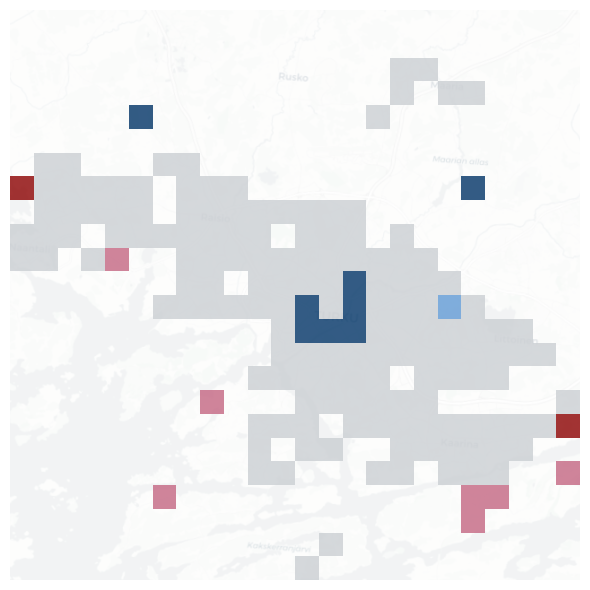

In [13]:
turku_cities = ['Turku', 'Kaarina', 'Naantali', 'Raisio']

city_data = grid_es[grid_es['city'].isin(turku_cities)].copy()
g = city_data.dropna(subset=['md_inc', 'es']).copy()

g = calculate_bivar_lisa(g, 'md_inc', 'es')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
g.plot(color=g['lisa_color'], linewidth=0, edgecolor='white', ax=ax, alpha=0.8)
ax.set_axis_off()


ax.set_xlim(226000, 250000)
ax.set_ylim(6700000, 6724000)

ctx.add_basemap(ax, crs=grid_es.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron, alpha=0.3,
                attribution = False)

ax.axis('off')
plt.tight_layout()
plt.show()

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_6152/1462844277.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(g, silence_warnings=True)
/Users/silver/anaconda3/envs/spatial/lib/python3.11/site-packages/esda/moran.py:1827: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


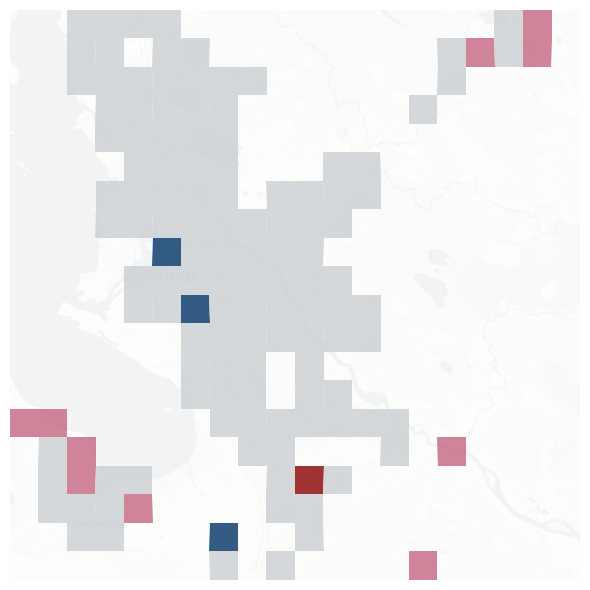

In [14]:
oulu_cities = ['Oulu', 'Kempele', 'Li','Liminka', 'Tyrnävä']

city_data = grid_es[grid_es['city'].isin(oulu_cities)].copy()
g = city_data.dropna(subset=['md_inc', 'es']).copy()

g = calculate_bivar_lisa(g, 'md_inc', 'es')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
g.plot(color=g['lisa_color'], linewidth=0, edgecolor='white', ax=ax, alpha=0.8)
ax.set_axis_off()


ax.set_xlim(422000,442000)
ax.set_ylim(7200000,7220000)

# NOW add basemap (if needed)
try:
    ctx.add_basemap(ax, crs=city_data.crs.to_string(), 
                   source=ctx.providers.CartoDB.Positron, alpha=0.3,
                   attribution = False)
except:
    pass

ax.axis('off')
plt.tight_layout()
plt.show()